# Test RECONSTRUCTION et METRIQUE

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ (K)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_file_npy = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    
    return tas

In [6]:
def map_plot(data, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [8]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [9]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_tas_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [10]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1  

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


In [11]:
#amip['official'] = official_amip
amip['p1'] = p1_amip
amip['p1']

<xarray.DataArray 'tas' (lat: 128, lon: 256)>
dask.array<mean_agg-aggregate, shape=(128, 256), dtype=float32, chunksize=(128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 ...
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

### Create EOF input matrix

In [12]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [13]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

### EOF analysis

In [14]:
# Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis]
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis]

S = wgts.sum()*256
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis]

In [15]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [16]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)#

In [17]:
anom_w = (anom*W_eof_3D)#

In [18]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [19]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=1)

In [20]:
varFrac = solver.varianceFraction(neigs=5)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 5)>
array([0.59029308, 0.14316059, 0.05863993, 0.03041701, 0.02783081])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  variance_fractions

### Save data

#### EOFs

In [21]:
for i in range(0,5,1) :
    j = i+1
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    # Save the numpy array in a file  
    EOF_df.to_pickle(path_file_npy+"/PPE2_EOFmap"+str(j)+"_"+str(variable)+".npy")

#### Principal Components

In [22]:
for i in range(0,5,1) :
    j = i+1
    pc_p1 = pc[0,i]
    PC = pc[1:,i]
    
    # Save the numpy array in a file   
    np.save(path_file_npy+'/p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_file_npy+'/PPE2_EOF'+str(j)+'pc_'+str(variable)+'.npy', PC)

#### Variance explained, Mean and Anomalies

In [23]:
## --VarFrac 
np.save(path_file_npy+'/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

## --Mean
mean_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_mean.npy')

## --Anom
anom_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_anom.npy')

# Projection observations

### Settings

In [24]:
product = 'BEST'
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
variable_obs = ['climatology', 'temperature']

### Get the data 

In [25]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [33]:
# POUR LES OBSERVATIONS BEST
path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()
clim = pd.concat([clim, clim, clim]).reset_index('month_number') # --Because 3 years (clim = 12 months)

df_obs=file['temperature'].to_dataframe().reset_index('time').fillna(0.0) # --Fill NA with 0 in anom
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature'] + df_obs['clim'] + 273.15 # --Add anom and clim + convert °C to K
variable_obs = 'ta'
df_obs

time  temperature       clim          ta
lat        lon                                                  
-88.927735 0.00000    1979.0     0.768801 -25.193111  248.725677
           1.40625    1979.0     0.769734 -25.215549  248.704178
           2.81250    1979.0     0.770550 -25.236740  248.683807
           4.21875    1979.0     0.771259 -25.256731  248.664520
           5.62500    1979.0     0.771860 -25.276089  248.645767
...                      ...          ...        ...         ...
 88.927735 352.96875  1981.0     0.004460 -30.711264  242.443192
           354.37500  1981.0    -0.004911 -30.734428  242.410660
           355.78125  1981.0    -0.016334 -30.728228  242.405426
           357.18750  1981.0    -0.024906 -30.703251  242.421844
           358.59375  1981.0    -0.041427 -30.653141  242.455429

[1179648 rows x 4 columns]

In [79]:
## --Test the Missing Values in BEST files 
clim = file['climatology'].to_dataframe()
df_obs=file['temperature'].to_dataframe()#.reset_index('time')

if clim.isna().values.any() : 
    print('NA in clim BEST')
      
if df_obs.isna().values.any() : 
    print('NA in anom BEST')
    test = df_obs.fillna(0)
    if test.isna().values.any() :
        print('Still NA in test')
    else : 
        print('No more NA in files')

else :
    print('No NA in files')

NA in anom BEST
No more NA in files


In [34]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 -46.88067 -46.921864 ... -19.784966
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

In [35]:
X_obs = obs[variable_obs] - Mean
X_obs_bis = X_obs*W_eof_2D
U_obs_avg = solver.projectField(X_obs_bis, neofs=5, weighted=False, eofscaling=1)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-0.64313456, -0.49760188,  1.76224663, -0.20957457,  3.64626966])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

In [36]:
## Test projection 
U_p1 = solver.projectField(anom_w[0], neofs=5, weighted=False, eofscaling=1)
U_p1

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 0.0401356 ,  0.92933824,  0.9555841 , -0.38580062,  0.09797457])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  tas_pseudo_pcs

In [78]:
## Test projection 
pc = [pc1_p1, pc2_p1, pc3_p1, pc4_p1, pc5_p1]
pc

[array(0.0401356),
 array(0.92933824),
 array(0.9555841),
 array(-0.38580062),
 array(0.09797457)]

### Save data

In [ ]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_obs_'+variable+'_'+product+'.npy', U_obs_avg)

# Test reconstruction p1

### Functions

In [38]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

### Get the data 

In [39]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [40]:
pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

### Reconstruction with home-made function VS package (q=5)

In [41]:
pc = [pc1_p1, pc2_p1, pc3_p1, pc4_p1, pc5_p1]
nb_dims = 2
X_rec_p1 = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_p1

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.22173019, -0.22173019, -0.22173019, ..., -0.22173019,
        -0.22173019, -0.22173019],
       [-0.39016836, -0.39016836, -0.39016836, ..., -0.39016836,
        -0.39016836, -0.39016836],
       [-0.4993325 , -0.4993325 , -0.4993325 , ..., -0.49190855,
        -0.4993325 , -0.4993325 ],
       ...,
       [ 0.15759325,  0.15759325,  0.15759325, ...,  0.15797455,
         0.15759325,  0.15759325],
       [ 0.14500147,  0.14500147,  0.14500147, ...,  0.14500147,
         0.14500147,  0.14500147],
       [ 0.10557362,  0.10557362,  0.10557362, ...,  0.10557362,
         0.10557362,  0.10557362]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [42]:
X_rec_pckg = solver.reconstructedField(5)
X_rec_pckg

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
array([[[-2.21730189e-01, -2.21730189e-01, -2.21730189e-01, ...,
         -2.21730189e-01, -2.21730189e-01, -2.21730189e-01],
        [-3.90168364e-01, -3.90168364e-01, -3.90168364e-01, ...,
         -3.90168364e-01, -3.90168364e-01, -3.90168364e-01],
        [-4.99332501e-01, -4.99332501e-01, -4.99332501e-01, ...,
         -4.91908547e-01, -4.99332501e-01, -4.99332501e-01],
        ...,
        [ 1.57593245e-01,  1.57593245e-01,  1.57593245e-01, ...,
          1.57974547e-01,  1.57593245e-01,  1.57593245e-01],
        [ 1.45001467e-01,  1.45001467e-01,  1.45001467e-01, ...,
          1.45001467e-01,  1.45001467e-01,  1.45001467e-01],
        [ 1.05573621e-01,  1.05573621e-01,  1.05573621e-01, ...,
          1.05573621e-01,  1.05573621e-01,  1.05573621e-01]],

       [[ 4.13484907e-01,  4.13484907e-01,  4.13484907e-01, ...,
          4.13484907e-01,  4.13484907e-01,  4.13484907e-01],
        [ 7.36210011e-01,  7.36210011e-01,  7.36210011e-01, ...,
          7.36210011e-01,  7.36210011e-01,  7.36210011e-01],
        [ 9.52121341e-01,  9.52121341e-01,  9.52121341e-01, ...,
          9.27948192e-01,  9.52121341e-01,  9.52121341e-01],
        ...,
        [-1.33783101e-01, -1.33783101e-01, -1.33783101e-01, ...,
         -1.31652990e-01, -1.33783101e-01, -1.33783101e-01],
        [-1.32810745e-01, -1.32810745e-01, -1.32810745e-01, ...,
         -1.32810745e-01, -1.32810745e-01, -1.32810745e-01],
        [-8.60829440e-02, -8.60829440e-02, -8.60829440e-02, ...,
         -8.60829440e-02, -8.60829440e-02, -8.60829440e-02]],

       [[-1.17515990e-01, -1.17515990e-01, -1.17515990e-01, ...,
         -1.17515990e-01, -1.17515990e-01, -1.17515990e-01],
        [-2.17177451e-01, -2.17177451e-01, -2.17177451e-01, ...,
         -2.17177451e-01, -2.17177451e-01, -2.17177451e-01],
        [-2.77271208e-01, -2.77271208e-01, -2.77271208e-01, ...,
         -2.63149436e-01, -2.77271208e-01, -2.77271208e-01],
        ...,
        [ 8.71556505e-02,  8.71556505e-02,  8.71556505e-02, ...,
          8.62618849e-02,  8.71556505e-02,  8.71556505e-02],
        [ 8.05340770e-02,  8.05340770e-02,  8.05340770e-02, ...,
          8.05340770e-02,  8.05340770e-02,  8.05340770e-02],
        [ 4.99271589e-02,  4.99271589e-02,  4.99271589e-02, ...,
          4.99271589e-02,  4.99271589e-02,  4.99271589e-02]],

       ...,

       [[ 8.84238527e-02,  8.84238527e-02,  8.84238527e-02, ...,
          8.84238527e-02,  8.84238527e-02,  8.84238527e-02],
        [ 2.74494058e-04,  2.74494058e-04,  2.74494058e-04, ...,
          2.74494058e-04,  2.74494058e-04,  2.74494058e-04],
        [ 1.42119407e-02,  1.42119407e-02,  1.42119407e-02, ...,
          1.64829796e-02,  1.42119407e-02,  1.42119407e-02],
        ...,
        [ 5.59239997e-01,  5.59239997e-01,  5.59239997e-01, ...,
          5.58510517e-01,  5.59239997e-01,  5.59239997e-01],
        [ 4.96968084e-01,  4.96968084e-01,  4.96968084e-01, ...,
          4.96968084e-01,  4.96968084e-01,  4.96968084e-01],
        [ 3.42715912e-01,  3.42715912e-01,  3.42715912e-01, ...,
          3.42715912e-01,  3.42715912e-01,  3.42715912e-01]],

       [[-3.09142913e-01, -3.09142913e-01, -3.09142913e-01, ...,
         -3.09142913e-01, -3.09142913e-01, -3.09142913e-01],
        [-4.86399706e-01, -4.86399706e-01, -4.86399706e-01, ...,
         -4.86399706e-01, -4.86399706e-01, -4.86399706e-01],
        [-6.65685458e-01, -6.65685458e-01, -6.65685458e-01, ...,
         -6.57082329e-01, -6.65685458e-01, -6.65685458e-01],
        ...,
        [-5.26117143e-01, -5.26117143e-01, -5.26117143e-01, ...,
         -5.30226011e-01, -5.26117143e-01, -5.26117143e-01],
        [-4.49363939e-01, -4.49363939e-01, -4.49363939e-01, ...,
         -4.49363939e-01, -4.49363939e-01, -4.49363939e-01],
        [-3.26724837e-01, -3.26724837e-01, -3.26724837e-01, ...,
         -3.26724837e-01, -3.26724837e-01, -3.26724837e-01]],

       [[-4.65897514e-01, -4.65897514e-01, -4.65897514e-01, ...,
         -

#### Tests

In [43]:
test = np.allclose(X_rec_p1, X_rec_pckg[0])
test

True

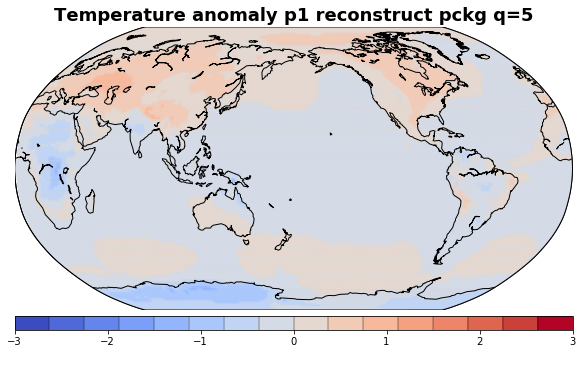

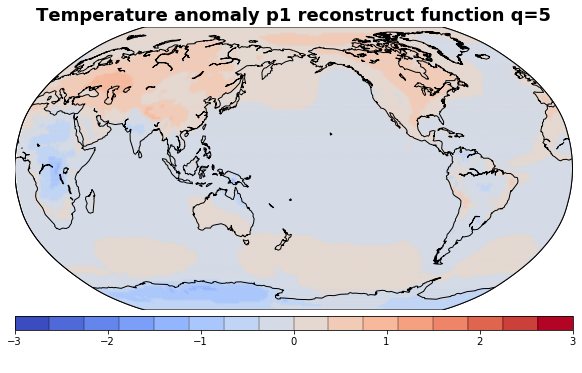

In [44]:
data = X_rec_pckg[0]
title = 'Temperature anomaly p1 reconstruct pckg q=5'
label_min = -3
label_max = 3
name_figure = 'tas_anom_p1_reconstruct_pckg_q5.png'
map_plot(data, title, label_min, label_max, name_figure)

data = X_rec_p1
title = 'Temperature anomaly p1 reconstruct function q=5'
label_min = -3
label_max = 3
name_figure = 'tas_anom_p1_reconstruct_fun_q5.png'
map_plot(data, title, label_min, label_max, name_figure)

### Reconstruction package (q=100) VS original 3D field 

In [45]:
X_rec_pckg = solver.reconstructedField(100)
df_pckg = pd.DataFrame(X_rec_pckg[0].values)
df_pckg

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.165816,-0.165816,-0.165816,-0.165816,-0.165816,-0.165816,-0.164004,-0.147712,-0.147712,-0.147712,...,-0.185126,-0.185126,-0.185126,-0.185126,-0.167756,-0.165816,-0.165816,-0.165816,-0.165816,-0.165816
1,-0.358115,-0.358115,-0.358115,-0.358115,-0.347776,-0.313835,-0.313835,-0.313835,-0.313835,-0.313835,...,-0.398232,-0.398232,-0.398232,-0.398232,-0.398232,-0.398232,-0.367468,-0.358115,-0.358115,-0.358115
2,-0.500359,-0.500359,-0.500359,-0.491659,-0.471357,-0.471357,-0.471357,-0.471357,-0.471357,-0.471357,...,-0.392968,-0.449253,-0.449253,-0.449253,-0.449253,-0.449253,-0.449253,-0.485025,-0.500359,-0.500359
3,-0.608784,-0.608784,-0.608784,-0.582477,-0.577225,-0.577225,-0.577225,-0.577225,-0.580688,-0.584124,...,-0.478940,-0.478940,-0.513554,-0.548163,-0.548163,-0.548163,-0.548163,-0.558254,-0.608784,-0.608784
4,-0.680420,-0.680420,-0.681354,-0.687518,-0.687518,-0.687518,-0.687518,-0.702993,-0.727281,-0.727281,...,-0.639593,-0.639593,-0.639593,-0.648755,-0.654599,-0.654599,-0.654599,-0.654599,-0.677081,-0.680420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.503879,0.503879,0.503303,0.499564,0.499564,0.499564,0.499564,0.508280,0.522047,0.522047,...,0.200719,0.200719,0.200719,0.306990,0.374606,0.374606,0.374606,0.374606,0.487121,0.503879
124,0.368104,0.368104,0.368104,0.372492,0.373392,0.373392,0.373392,0.373392,0.389246,0.405119,...,0.300062,0.300062,0.325751,0.351421,0.351421,0.351421,0.351421,0.354199,0.368104,0.368104
125,0.190146,0.190146,0.190146,0.214901,0.272641,0.272641,0.272641,0.272641,0.272641,0.272641,...,0.112788,0.127830,0.127830,0.127830,0.127830,0.127830,0.127830,0.171436,0.190146,0.190146
126,0.196391,0.196391,0.196391,0.196391,0.202255,0.221492,0.221492,0.221492,0.221492,0.221492,...,0.176356,0.176356,0.176356,0.176356,0.176356,0.176356,0.191723,0.196391,0.196391,0.196391


In [46]:
df_anom = pd.DataFrame(anom_w[0].values)
df_anom

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.166143,-0.166143,-0.166143,-0.166143,-0.166143,-0.166143,-0.164352,-0.148255,-0.148255,-0.148255,...,-0.185195,-0.185195,-0.185195,-0.185195,-0.168060,-0.166143,-0.166143,-0.166143,-0.166143,-0.166143
1,-0.357695,-0.357695,-0.357695,-0.357695,-0.347498,-0.314024,-0.314024,-0.314024,-0.314024,-0.314024,...,-0.397762,-0.397762,-0.397762,-0.397762,-0.397762,-0.397762,-0.367036,-0.357695,-0.357695,-0.357695
2,-0.499870,-0.499870,-0.499870,-0.491399,-0.471636,-0.471636,-0.471636,-0.471636,-0.471636,-0.471636,...,-0.391797,-0.448072,-0.448072,-0.448072,-0.448072,-0.448072,-0.448072,-0.484334,-0.499870,-0.499870
3,-0.608166,-0.608166,-0.608166,-0.581666,-0.576378,-0.576378,-0.576378,-0.576378,-0.580378,-0.584350,...,-0.478732,-0.478732,-0.513217,-0.547698,-0.547698,-0.547698,-0.547698,-0.557763,-0.608166,-0.608166
4,-0.679252,-0.679252,-0.680203,-0.686453,-0.686453,-0.686453,-0.686453,-0.702205,-0.726920,-0.726920,...,-0.638374,-0.638374,-0.638374,-0.647539,-0.653384,-0.653384,-0.653384,-0.653384,-0.675911,-0.679252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.503012,0.503012,0.502358,0.498045,0.498045,0.498045,0.498045,0.506722,0.520427,0.520427,...,0.202695,0.202695,0.202695,0.308505,0.375838,0.375838,0.375838,0.375838,0.486532,0.503012
124,0.366721,0.366721,0.366721,0.371100,0.371996,0.371996,0.371996,0.371996,0.388181,0.404375,...,0.298258,0.298258,0.324125,0.349954,0.349954,0.349954,0.349954,0.352753,0.366721,0.366721
125,0.188778,0.188778,0.188778,0.213470,0.271046,0.271046,0.271046,0.271046,0.271046,0.271046,...,0.111659,0.126886,0.126886,0.126886,0.126886,0.126886,0.126886,0.170198,0.188778,0.188778
126,0.196132,0.196132,0.196132,0.196132,0.201975,0.221137,0.221137,0.221137,0.221137,0.221137,...,0.175749,0.175749,0.175749,0.175749,0.175749,0.175749,0.191385,0.196132,0.196132,0.196132


In [47]:
test = np.allclose(anom_w[0], X_rec_pckg[0])
test

False

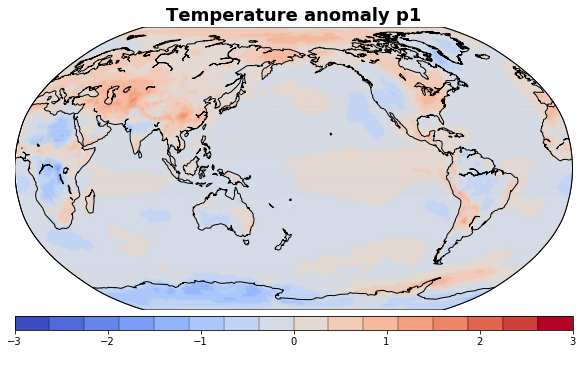

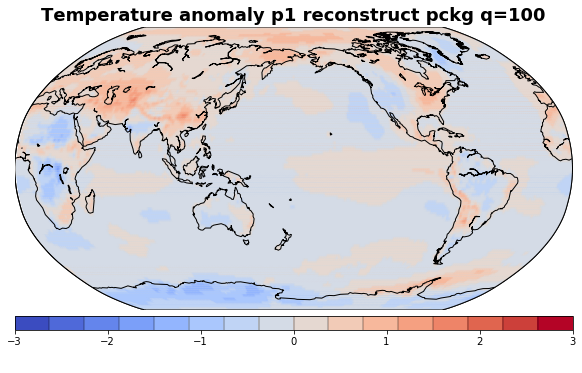

In [48]:
data = anom_w[0]
title = 'Temperature anomaly p1'
label_min = -3
label_max = 3
name_figure = 'tas_anom_p1.png'
map_plot(data, title, label_min, label_max, name_figure)

data = X_rec_pckg[0]
title = 'Temperature anomaly p1 reconstruct pckg q=100'
label_min = -3
label_max = 3
name_figure = 'tas_anom_p1_reconstruct_pckg_q100.png'
map_plot(data, title, label_min, label_max, name_figure)

# Test RMSE p1 

### Functions

In [49]:
N_error = 128*256

In [50]:
def RMSE(mod, obs) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [51]:
def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs)
    return diff

### Get and recosntruct data

In [52]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'_'+product+'.npy')

In [53]:
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_obs 

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 0.00909111,  0.00909111,  0.00909111, ...,  0.00909111,
         0.00909111,  0.00909111],
       [ 0.04936855,  0.04936855,  0.04936855, ...,  0.04936855,
         0.04936855,  0.04936855],
       [ 0.05452745,  0.05452745,  0.05452745, ...,  0.03465445,
         0.05452745,  0.05452745],
       ...,
       [-0.14799932, -0.14799932, -0.14799932, ..., -0.14657692,
        -0.14799932, -0.14799932],
       [-0.13108438, -0.13108438, -0.13108438, ..., -0.13108438,
        -0.13108438, -0.13108438],
       [-0.07839911, -0.07839911, -0.07839911, ..., -0.07839911,
        -0.07839911, -0.07839911]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [54]:
pc = [pc1_p1, pc2_p1, pc3_p1, pc4_p1, pc5_p1,]
nb_dims = 2
X_rec_p1 = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_p1

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.22173019, -0.22173019, -0.22173019, ..., -0.22173019,
        -0.22173019, -0.22173019],
       [-0.39016836, -0.39016836, -0.39016836, ..., -0.39016836,
        -0.39016836, -0.39016836],
       [-0.4993325 , -0.4993325 , -0.4993325 , ..., -0.49190855,
        -0.4993325 , -0.4993325 ],
       ...,
       [ 0.15759325,  0.15759325,  0.15759325, ...,  0.15797455,
         0.15759325,  0.15759325],
       [ 0.14500147,  0.14500147,  0.14500147, ...,  0.14500147,
         0.14500147,  0.14500147],
       [ 0.10557362,  0.10557362,  0.10557362, ...,  0.10557362,
         0.10557362,  0.10557362]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

### Compute E_p1 and RMSE 

In [55]:
E_p1 = RMSE_rec(X_rec_p1, X_rec_obs, Mean)
E_p1

<xarray.DataArray ()>
array(0.83593341)

In [56]:
mod = amip_list[0]
observation = obs['ta']
RMSE_p1 = RMSE(mod, observation)
RMSE_p1.values

array(1.41886474)

# Check correlation RMSE_rec (EOF space) vs RMSE

### Functions 

In [57]:
N_error = (128*256)

In [58]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [59]:
def RMSE(mod, obs) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [60]:
def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs)
    return diff

### Get the data 

In [61]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [62]:
pc_PPE=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/PPE2_EOF'+str(i)+'pc_'+str(variable)+'.npy')
    pc_PPE.append(pc_tmp)

In [63]:
X_PPE = []
for i in range(0,102,1) :
    pc = [pc_PPE[0][i], pc_PPE[1][i], pc_PPE[2][i], pc_PPE[3][i], pc_PPE[4][i]]
    nb_dims = 2
    X_PPE_tmp = reconstruct_X(eofs_combined, pc, nb_dims)
    
    X_PPE.append(X_PPE_tmp)


In [64]:
#X_PPE = []
#pc = pc_PPE
#nb_dims = 3
#X_PPE = reconstruct_X(eofs_combined, pc, nb_dims)

In [65]:
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

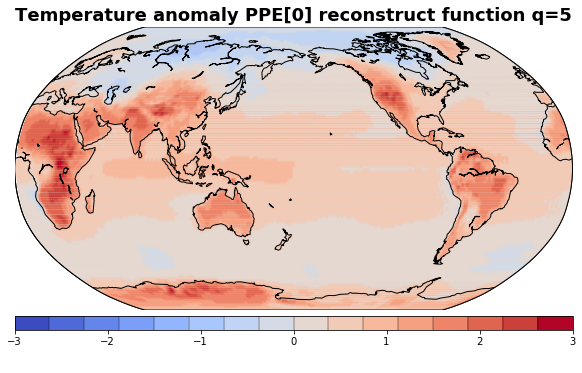

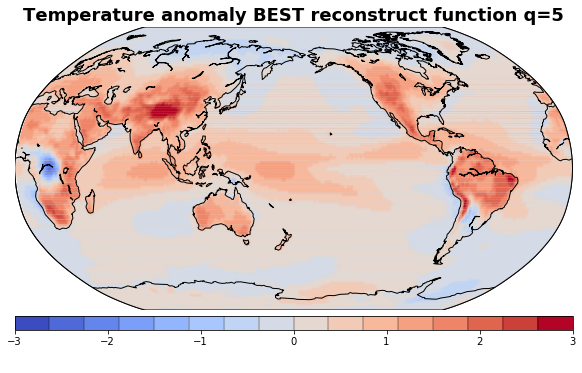

In [66]:
data = X_PPE[0]
title = 'Temperature anomaly PPE[0] reconstruct function q=5'
label_min = -3
label_max = 3
name_figure = 'Test.png'
map_plot(data, title, label_min, label_max, name_figure)

data = X_rec_obs 
title = 'Temperature anomaly BEST reconstruct function q=5'
label_min = -3
label_max = 3
name_figure = 'Test.png'
map_plot(data, title, label_min, label_max, name_figure)

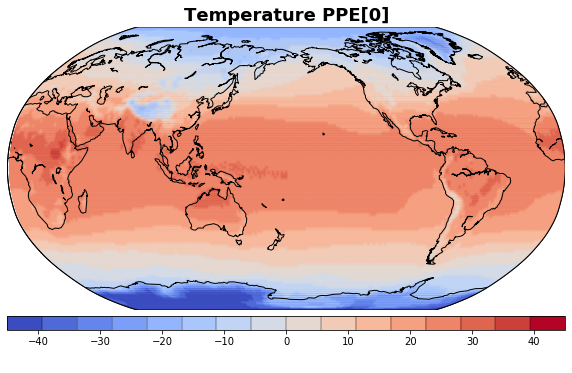

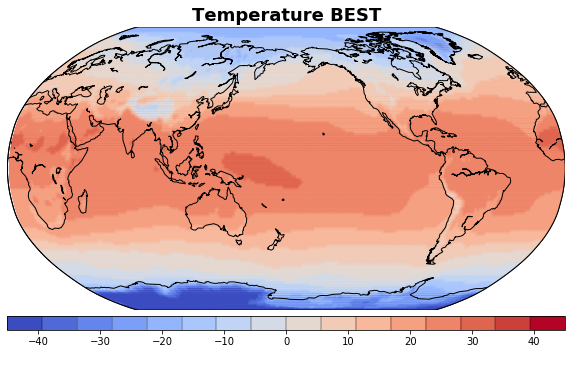

In [72]:
mod_list = amip_list[1:]  ## --Because amip_list[0] is p1
data = mod_list[0] - 273.15
title = 'Temperature PPE[0]'
label_min = -45
label_max = 45
name_figure = 'Test.png'
map_plot(data, title, label_min, label_max, name_figure)

data = obs['ta'] - 273.15
title = 'Temperature BEST'
label_min = -45
label_max = 45
name_figure = 'Test.png'
map_plot(data, title, label_min, label_max, name_figure)

In [73]:
E_PPE = []
RMSE_PPE = []
observation = obs['ta']
mod_list = amip_list[1:]  ## --Because amip_list[0] is p1

for i in range(0,len(X_PPE),1) :
    E_PPE_tmp = RMSE_rec(X_PPE[i], X_rec_obs, Mean)
    RMSE_PPE_tmp = RMSE(mod_list[i], observation)
    
    E_PPE.append(float(E_PPE_tmp))
    RMSE_PPE.append(float(RMSE_PPE_tmp))

In [74]:
df_fig = pd.DataFrame(E_PPE, columns=['E_PPE'])
df_fig['RMSE_PPE'] = RMSE_PPE
df_fig

,E_PPE,RMSE_PPE
0,0.646833,1.357978
1,1.252210,1.728649
2,1.525655,1.932720
3,1.219597,1.686399
4,1.029925,1.530717
...,...,...
97,1.514299,1.896896
98,1.324064,1.772533
99,1.112656,1.649896
100,1.769320,2.112006


In [75]:
E = df_fig['E_PPE']
R = df_fig['RMSE_PPE']
coeff1 = (E[90] - E[85])/(R[90] - R[85])
coeff2 = (E[50] - E[45])/(R[50] - R[45])
coeff3 = (E[100] - E[95])/(R[100] - R[95])
coeff4 = (E[80] - E[75])/(R[80] - R[75])
coeff5 = (E[60] - E[55])/(R[60] - R[55])
coeff6 = (E[101] - E[96])/(R[101] - R[96])
coeff = (coeff1 + coeff2 + coeff3 + coeff4 + coeff5)/5
line_tmp = R*coeff
intercept = E.mean() - line_tmp.mean()
line = np.arange(1.2,2.6,0.02)*coeff 
line = line + intercept

In [76]:
diag_x = np.arange(0,3,0.02)
diag_y = np.arange(0,3,0.02)

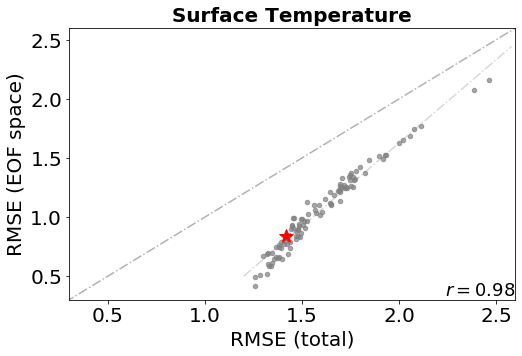

In [77]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='E_PPE', x='RMSE_PPE', color = 'gray', alpha=0.7, ax=ax)
plt.plot(RMSE_p1, E_p1, marker="*", markersize=15, markeredgecolor="red", markerfacecolor="red")
ax.plot(np.arange(1.2,2.6,0.02), line, linestyle="-.", alpha=0.3,  color='gray')
ax.plot(diag_x, diag_y, linestyle="-.", alpha=0.3,  color='black')

ax.set_xlabel('RMSE (total)', size = 20)
ax.set_ylabel('RMSE (EOF space)', size = 20)
ax.set_title('Surface Temperature', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = 0.98$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

plt.xlim([0.3, 2.6])
plt.ylim([0.3, 2.6])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()